In [1]:
import os
import time
import bisect
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def quantize(flat_img, intervals=5, bins=256):
    '''
    Perform quantization of range on a flattened image.

    Parameters
    ----------
    flat_img : numpy.ndarray
        A flattened image.
    intervals : int, optional
        Number of intervals (in the range of the image). The default is 5.
    bins : int, optional
        Number of bins. The default is 256.

    Returns
    -------
    numpy.ndarray
        Quantized (flat) image.
    '''
    hist, _ = np.histogram(flat_img, bins)
    max_pixels_per_interval = len(flat_img)/intervals

    upper_bounds = [0]
    reconstr_vals = []

    pixels_in_interval = 0  # number of pixels in the current interval
    reconstr_val = 0  # reconstruction value of the current interval
    for i in range(bins):
        pixels_in_interval += hist[i]
        reconstr_val += i * hist[i]
        if pixels_in_interval > max_pixels_per_interval:
            upper_bounds.append(i)
            reconstr_vals.append(reconstr_val/pixels_in_interval)
            pixels_in_interval = 0
    upper_bounds.append(i)
    reconstr_vals.append(reconstr_val/pixels_in_interval)

    flat_quant = []
    for val in flat_img:
        # NOTE could use binary search here since upper_bounds is sorted
        for i in range(intervals):
            if upper_bounds[i] <= val < upper_bounds[i+1]:
                flat_quant.append(reconstr_vals[i])
                break
    return np.array(flat_quant)

def quantize_bs(flat_img, intervals=5, bins=256):
    '''
    Perform quantization of range on a flattened image.

    Parameters
    ----------
    flat_img : numpy.ndarray
        A flattened image.
    intervals : int, optional
        Number of intervals (in the range of the image). The default is 5.
    bins : int, optional
        Number of bins. The default is 256.

    Returns
    -------
    numpy.ndarray
        Quantized (flat) image.
    '''
    hist, _ = np.histogram(flat_img, bins)
    max_pixels_per_interval = len(flat_img)/intervals

    upper_bounds = [0]
    reconstr_vals = []

    pixels_in_interval = 0  # number of pixels in the current interval
    reconstr_val = 0  # reconstruction value of the current interval
    for i in range(bins):
        pixels_in_interval += hist[i]
        reconstr_val += i * hist[i]
        if pixels_in_interval > max_pixels_per_interval:
            upper_bounds.append(i)
            reconstr_vals.append(reconstr_val/pixels_in_interval)
            pixels_in_interval = 0
    upper_bounds.append(i)
    reconstr_vals.append(reconstr_val/pixels_in_interval)

    flat_quant = []
    for val in flat_img:
        i = bisect.bisect_right(upper_bounds, val)
        flat_quant.append(reconstr_vals[i-1])
    return np.array(flat_quant)

Image shape:  (1365, 2048)
Time taken for quantize:  5.6218493200030935
Time taken for quantize_bs:  2.5277918849969865


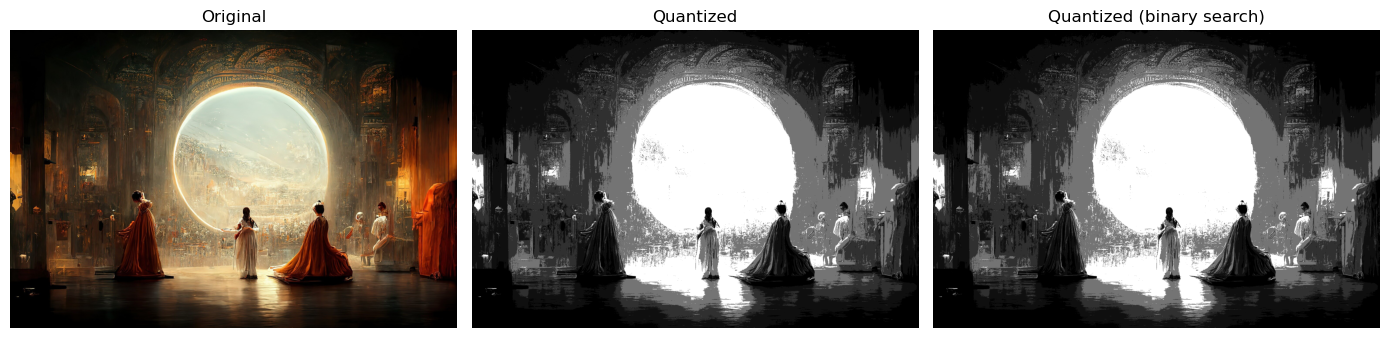

In [3]:
# get file path
# THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
# file_name = 'vanGogh'
# file_type = '.JPG'
# file_path = os.path.join(THIS_FOLDER, file_name + file_type)
file_path = 'theatre-dopera-spatial.jpg'

# load image file and convert it into grayscale
img = mpimg.imread(file_path)
rgb_weights = [0.2989, 0.5870, 0.1140]
gray_img = np.dot(img[..., :3], rgb_weights)
print('Image shape: ', gray_img.shape)

# flatten gray_img and pass it to histogram
flat_img = gray_img.flatten()
# plt.hist(flat_img, bins=256)
# plt.show()

# quantize flat_img
t0 = time.perf_counter()
quant_img = quantize(flat_img).reshape(gray_img.shape)
t1 = time.perf_counter()
quant_img_bs = quantize_bs(flat_img).reshape(gray_img.shape)
t2 = time.perf_counter()

print('Time taken for quantize: ', t1-t0)
print('Time taken for quantize_bs: ', t2-t1)

# plot images
fig, axs = plt.subplots(1, 3, figsize=(14, 7))
axs[0].imshow(img)
axs[0].set_title('Original')
axs[1].imshow(quant_img, cmap='gray')
axs[1].set_title('Quantized')
axs[2].imshow(quant_img_bs, cmap='gray')
axs[2].set_title('Quantized (binary search)')
for ax in axs:
    ax.axis('off')
fig.tight_layout()
plt.show()

# # save quantized img
# mpimg.imsave(file_name + '_quant' + file_type, quant_img, cmap='gray')

In [4]:
np.all(quant_img == quant_img_bs)

True